# *Многомерная модель на LSTM* (1 слой)

В качестве признаков используются цены, объём торгов и некоторое число индикаторов (всего 18 признаков)

In [1]:
import os
import glob
import datetime
import pickle

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from pandas_datareader import data as pdr

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [5]:
import tensorflow as tf
# tf.test.is_gpu_available()
tf.__version__

'2.0.0'

In [6]:
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Flatten, ReLU, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Nadam

In [7]:
from mdp import TimeSeries
from mdp import MarketData
from mdp import MovingWindowFeatures
from mdp import ClassificationGenerator, RegressionGenerator, MultitaskGenerator
from mdp import invert_log_ret

import mdp.utils as utils
import mdp.plotHelpers as plotHelpers

In [8]:
import importlib

import mdp

importlib.reload(mdp)
importlib.reload(mdp.datasetGenerator)
importlib.reload(mdp.marketData)
importlib.reload(mdp.movingWindowFeatures)
importlib.reload(mdp.timeSeries)
importlib.reload(mdp.plotHelpers)
importlib.reload(mdp.utils);

# *Параметры*

In [9]:
INSTRUMENT = 'MSFT' # Microsoft corp
START_FROM = np.datetime64('today') - 7
WINDOW_SIZE = 120
FORECAST_OFFSET=1
BATCH_SIZE = 32
FORCE_TRAIN = True

# *Исходные данные*

Загрузка данных и вычисление индикаторов.

In [10]:
instr = MarketData.create_from_alphavantage_intraday(INSTRUMENT, start=START_FROM)

In [11]:
instr.feature_names

['o',
 'h',
 'l',
 'c',
 'v',
 'ema14',
 'ema30',
 'macd',
 'macd_signal',
 'rsi14',
 'bband20_upper',
 'bband20_middle',
 'bband20_lower',
 'willr14',
 'stochk',
 'stochd',
 'adline',
 'adosc']

Здесь не будем делить отдельно на тест и валидацию, поскольку данных у нас только 5 дней.

In [12]:
dates_unique = np.unique(instr.timestamps.astype('datetime64[D]'))

START_FROM = dates_unique[0]
VAL_TEST_SPLIT = dates_unique[-1]

START_FROM, VAL_TEST_SPLIT

(numpy.datetime64('2020-04-09'), numpy.datetime64('2020-04-15'))

## Целевая переменная

Цена закрытия.

In [13]:
orig_target = instr.c

Переходим к логарифмической доходности.

In [14]:
transformed_target = instr.c.transform(transforms={'ratios' : {}, 'ln' : {}})

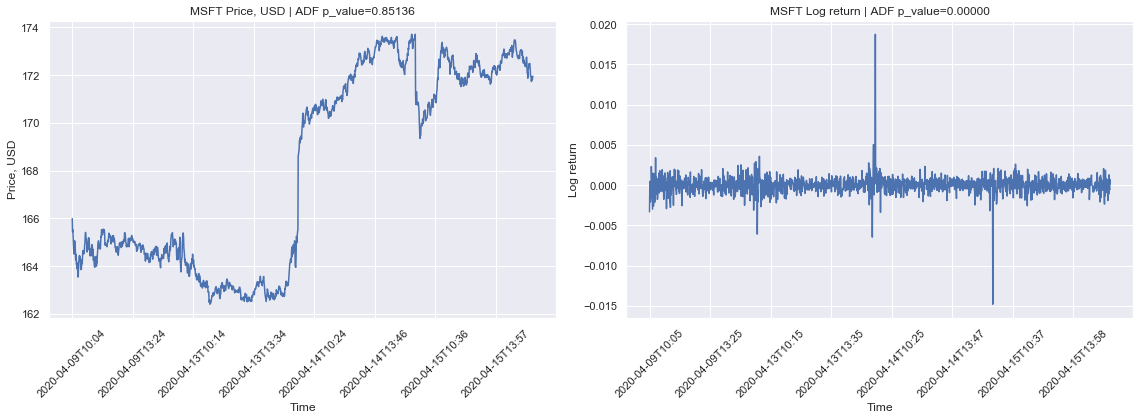

In [15]:
plotHelpers.plot_transformed_timeseries_unit(instr,
                                             transformed_target,
                                             'Price, USD', 'Log return',
                                             datetime_unit='m', rotation=45)

## Трансформация признаков

Приведение временных рядов к стационарности.

In [16]:
def make_feature_selector():
    price_transformer = lambda: {'ratios': {}, 'ln': {}}
    diff_transformer = lambda o: {'diffs': {'order': o}}
    identity_transformer = lambda: {}
    feature_transformations = {
        'o': price_transformer(),
        'h': price_transformer(),
        'l': price_transformer(),
        'c': price_transformer(),
        'v': diff_transformer(1),
        'ema14': diff_transformer(1),
        'ema30': diff_transformer(1),
        'macd': identity_transformer(),
        'macd_signal': identity_transformer(),
        'rsi14': identity_transformer(),
        'bband20_upper': diff_transformer(1),
        'bband20_middle': diff_transformer(1),
        'bband20_lower': diff_transformer(1),
        'willr14': identity_transformer(),
        'stochd': identity_transformer(),
        'stochk': identity_transformer(),
        'adline': diff_transformer(1),
        'adosc': identity_transformer()
    }
    return feature_transformations

In [17]:
instr_transformed = instr.select_transform(make_feature_selector())

In [18]:
transformed_target = instr_transformed.c

## Обучающая, валидационная и тестовая выборки

In [19]:
instr_train, instr_test = instr_transformed.train_test_split(VAL_TEST_SPLIT, window_size=WINDOW_SIZE,
                                                             scaler=StandardScaler)
#                                                              scaler=MinMaxScaler,
#                                                              scaler_kwargs={'feature_range': (-1, 1)})

# instr_val, instr_test = instr_val_test.train_test_split(TEST_SPLIT, window_size=WINDOW_SIZE, scaler=None)

len(instr_train), len(instr_test)

(1134, 509)

Все отмасштабированные признаки на одном графике (для валидационного датасета):

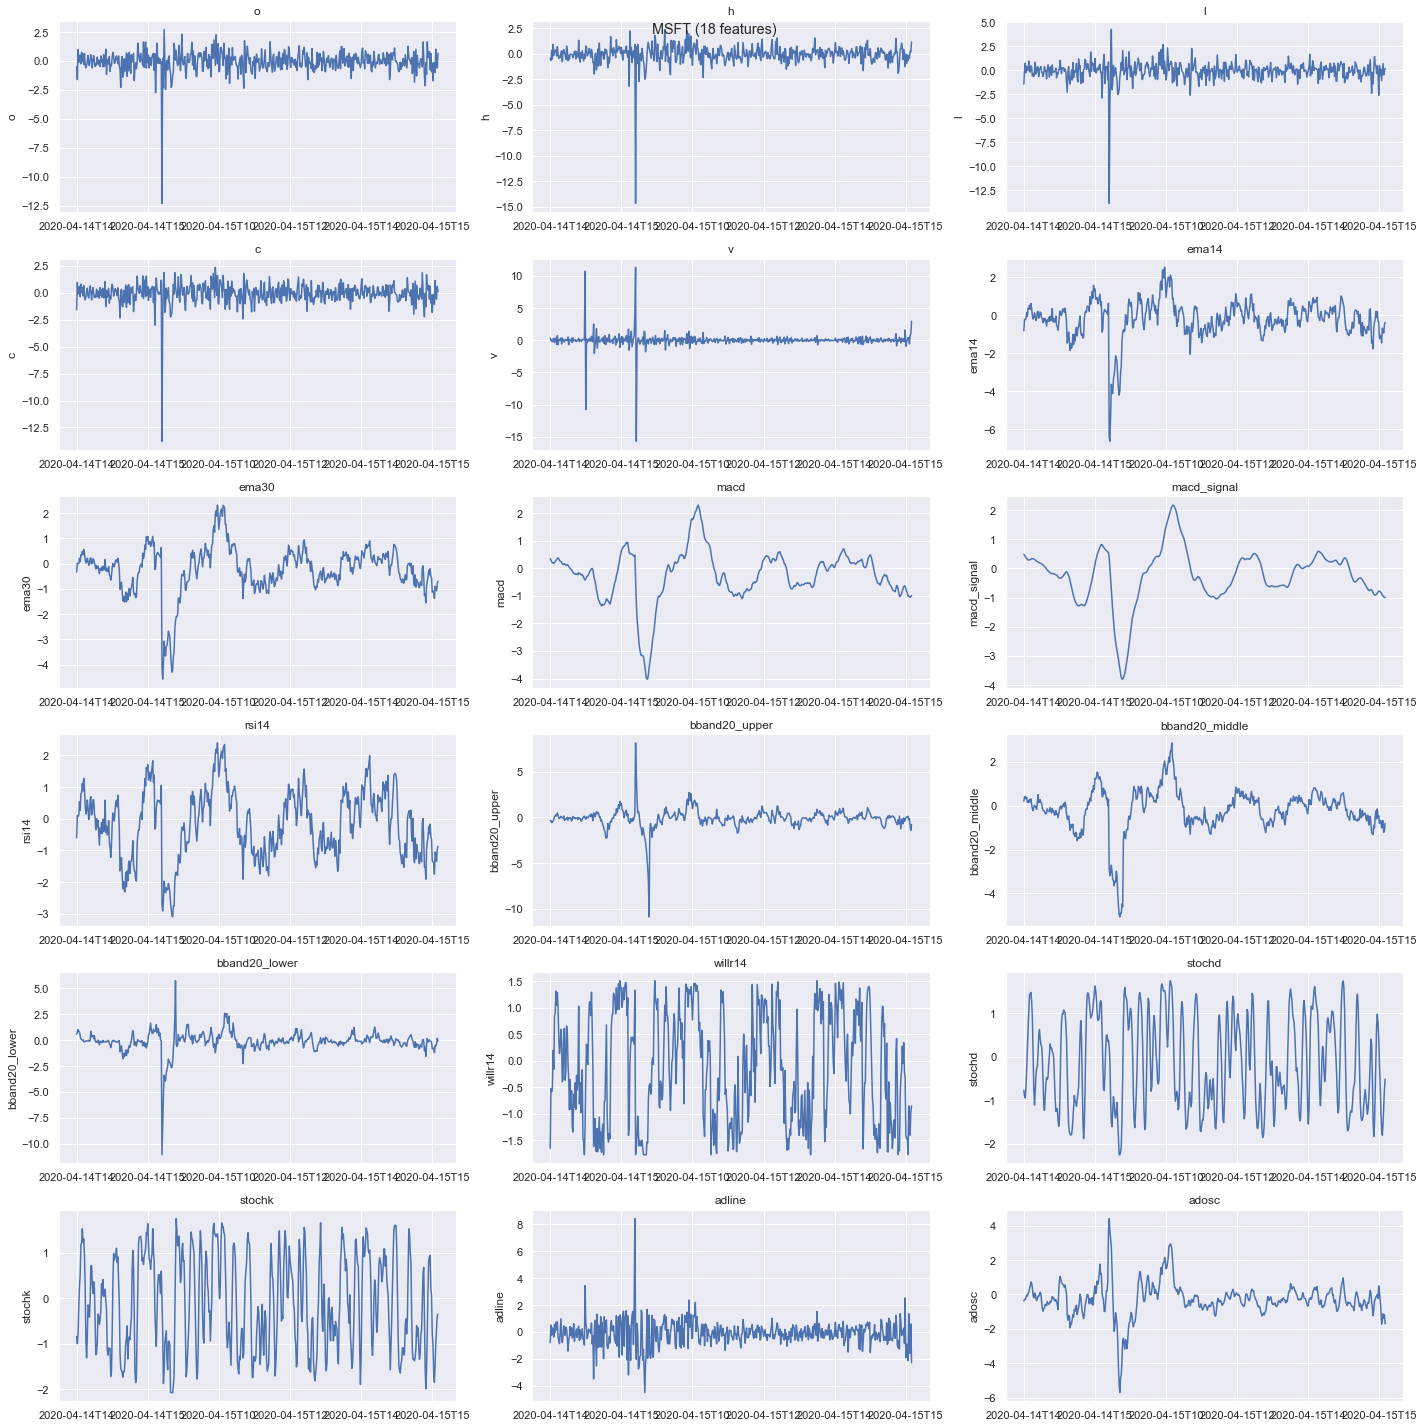

In [20]:
plotHelpers.plot_all_features(instr_test, datetime_unit='h', rotation=0)

## Признаки - скользящие окна

In [21]:
train_mwf = MovingWindowFeatures.create(instr_train.c, [instr_train], instr_train.feature_names, window_size=WINDOW_SIZE)
# val_mwf = MovingWindowFeatures.create(instr_val.c, [instr_val], instr_val.feature_names, window_size=WINDOW_SIZE)
test_mwf = MovingWindowFeatures.create(instr_test.c, [instr_test], instr_test.feature_names, window_size=WINDOW_SIZE)

len(instr_train), len(train_mwf), train_mwf.features.shape

(1134, 1014, (1014, 120, 18))

Проверка, что скользящие окна соответствуют исходным данным.

Возьмём произвольный признак и произвольное окно (строка #**41**). Проверим, что данные в точности совпадают:

In [22]:
def check_data(md, mwf, row):
    col = np.random.randint(len(mwf.feature_names))
    feature = mwf.feature_names[col]
    check = (getattr(md, feature).data[row:row + mwf.window_size] == mwf.features[row, :, col]).all()
    assert check
    return feature, check

check_data(instr_train, train_mwf, 41)

('macd', True)

# *Модели*

Модель с одним LSTM слоем.

In [23]:
def build_lstm_layers(input_shape, latent_dim=16):
    # формат входа: матрица (окно; признак)
    inp = Input(input_shape, name='input')

    lstm = LSTM(latent_dim, return_sequences=True,
                    recurrent_dropout=0.2, dropout=0.2,
                    bias_initializer='he_uniform',
                    bias_regularizer=L1L2(0.01, 0.02),
                    kernel_regularizer=L1L2(0.01, 0.02),
                    recurrent_regularizer=L1L2(0.01, 0.02)
               )(inp)
    
    lstm = Flatten()(lstm)
    
    return inp, lstm

#### Пути сохранения моделей:

In [24]:
model_path_root = 'models'
model_type_name = 'lstm1_multivar'

def make_model_save_dir(path_root, type_name, class_name):
    save_dir = os.path.join(path_root, type_name, class_name)
    os.makedirs(save_dir, exist_ok=True)
    return save_dir

#### Общие коллбэки:

In [25]:
# уменьшение learning rate в случае, если loss не изменяется
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001, verbose=1)

# уменьшение learning rate в 2 раза каждую 5-ю эпоху
def lr_decay(e, lr):
    return lr * (1 - 0.5 * (0 == (e + 1) % 5))

lr_scheduler = LearningRateScheduler(schedule=lr_decay, verbose=1)

## Задача регрессии

Непосредственное прогнозирование цены следующего периода.

In [26]:
train_regr_gen = RegressionGenerator.create(train_mwf, batch_size=BATCH_SIZE)
# val_regr_gen = RegressionGenerator.create(test_mwf, batch_size=BATCH_SIZE, shuffle=False)
test_regr_gen = RegressionGenerator.create(test_mwf, batch_size=BATCH_SIZE, shuffle=False)

Следующие числа соответствуют значению параметра `steps_per_epoch` метода [`fit_generator`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit_generator "tf.keras.layers.SimpleRNN &nbsp;|&nbsp; TensorFlow Core r2.0") - то есть это число батчей, которые генератор выдаст за одну эпоху обучения (если класс генератора поддерживает метод `len()`, то данный параметр можно не указывать).

In [27]:
len(train_regr_gen), len(test_regr_gen)

(32, 13)

Один сэмпл данных представляет собой матрицу размером *(длина окна; число признаков)*

In [28]:
train_regr_gen.input_shape

(120, 18)

### Модель для задачи регрессии

In [29]:
model_class_name = 'regression'

In [30]:
def build_regression_model(input_shape):
    inp, lstm = build_lstm_layers(input_shape, latent_dim=32)

    regr = Dense(64)(lstm)
    regr = LeakyReLU()(regr)
    regr = BatchNormalization()(regr)
    regr = Dropout(0.5)(regr)
    regr = Dense(1, activation='linear', name='regr')(regr)

    return Model(inputs=[inp], outputs=[regr])

In [31]:
multivariate_regression_lstm = build_regression_model(train_regr_gen.input_shape)

model_save_dir = make_model_save_dir(model_path_root, model_type_name, model_class_name)

#### Оптимизатор:
[`Nadam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Nadam) (*Adam with Nestrov momentum*).

In [32]:
optimizer = Nadam(lr=0.001, clipnorm=0.5)

#### Дополнительные коллбэки:

In [33]:
checkpointer = ModelCheckpoint(monitor='val_loss', verbose=1, save_best_only=True,
                               filepath=os.path.join(model_save_dir, '{epoch:02d}.hdf5'))

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, verbose=1)

#### Функция потерь:

В качестве функции потерь будем использовать [MSE](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MSE) (чтобы штрафовать за большие отклонения). Xотя хорошая функция потерь в контексте темы данной задачи - это [вопрос сложный](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter5_LossFunctions/Ch5_LossFunctions_PyMC3.ipynb). В частности, здесь нам, очевидно, помимо абсолютного значения отклонения также важен его знак.

In [34]:
multivariate_regression_lstm.compile(optimizer=optimizer,
                                     loss={'regr': 'mse'},
                                     metrics={'regr': 'mae'})

multivariate_regression_lstm.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 120, 18)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 120, 32)           6528      
_________________________________________________________________
flatten (Flatten)            (None, 3840)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                245824    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0     

#### Обучение:

In [35]:
regr_history = utils.train_model(multivariate_regression_lstm,
                                 model_save_dir, train_regr_gen, test_regr_gen,
                                 callbacks=[reduce_lr, lr_scheduler, checkpointer, earlyStopping],
                                 force_train=FORCE_TRAIN, verbose=1)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/32
31/32 [============================>.] - ETA: 1s - loss: 11.5872 - mae: 1.5472
Epoch 00001: val_loss improved from inf to 8.37755, saving model to models\lstm1_multivar\regression\01.hdf5
32/32 [==============================] - 40s 1s/step - loss: 11.4976 - mae: 1.5358 - val_loss: 8.3776 - val_mae: 0.7408

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/32
31/32 [============================>.] - ETA: 1s - loss: 9.5555 - mae: 1.2311
Epoch 00002: val_loss improved from 8.37755 to 8.06287, saving model to models\lstm1_multivar\regression\02.hdf5
32/32 [==============================] - 39s 1s/step - loss: 9.5322 - mae: 1.2307 - val_loss: 8.0629 - val_mae: 0.9727

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/32
31/32 [============================>.] - ETA: 1s - loss: 8.4179 - mae: 1.1214
Epoch 00003: val

31/32 [============================>.] - ETA: 1s - loss: 4.2941 - mae: 0.8575
Epoch 00021: val_loss improved from 3.92363 to 3.88167, saving model to models\lstm1_multivar\regression\21.hdf5
32/32 [==============================] - 47s 1s/step - loss: 4.2712 - mae: 0.8555 - val_loss: 3.8817 - val_mae: 0.6921

Epoch 00022: LearningRateScheduler reducing learning rate to 6.25000029685907e-05.
Epoch 22/32
31/32 [============================>.] - ETA: 1s - loss: 4.0651 - mae: 0.8142
Epoch 00022: val_loss improved from 3.88167 to 3.87395, saving model to models\lstm1_multivar\regression\22.hdf5
32/32 [==============================] - 47s 1s/step - loss: 4.0780 - mae: 0.8184 - val_loss: 3.8740 - val_mae: 0.6978

Epoch 00023: LearningRateScheduler reducing learning rate to 6.25000029685907e-05.
Epoch 23/32
31/32 [============================>.] - ETA: 1s - loss: 4.1277 - mae: 0.8289
Epoch 00023: val_loss improved from 3.87395 to 3.85768, saving model to models\lstm1_multivar\regression\23.hd

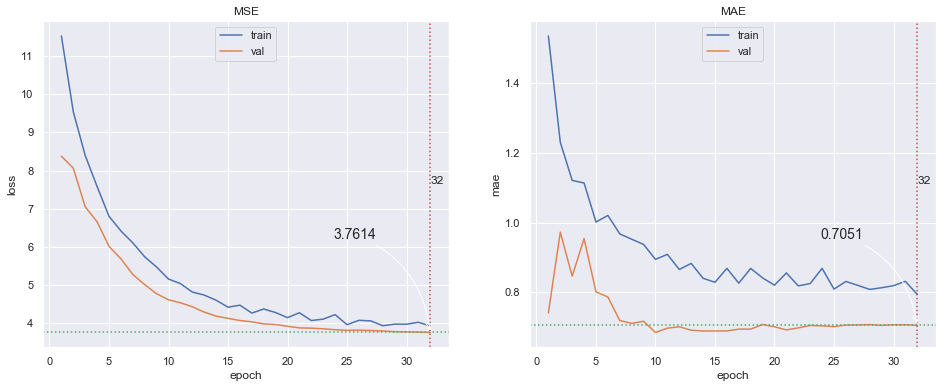

In [36]:
def plot_regr_history(hist):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    plotHelpers.plot_train_history(ax[0], hist, 'MSE', 'loss', 'val_loss')
    plotHelpers.plot_train_history(ax[1], hist, 'MAE', 'mae', 'val_mae')
    
plot_regr_history(regr_history);

### Прогноз задачи регрессии

In [37]:
# загружаем последнюю эпоху с минимальным лоссом
multivariate_regression_lstm.load_weights(sorted(glob.glob(os.path.join(model_save_dir,'*.hdf5')))[-1])

#### На тесте:

In [38]:
pred_log_ret_test = multivariate_regression_lstm.predict_generator(test_regr_gen, verbose=1)

13/13 [==============================] - 8s 606ms/step


*Открылось с сильным гэпом вниз, поэтому для более наглядной визуализации на графике пропускаем первые несколько минут*:

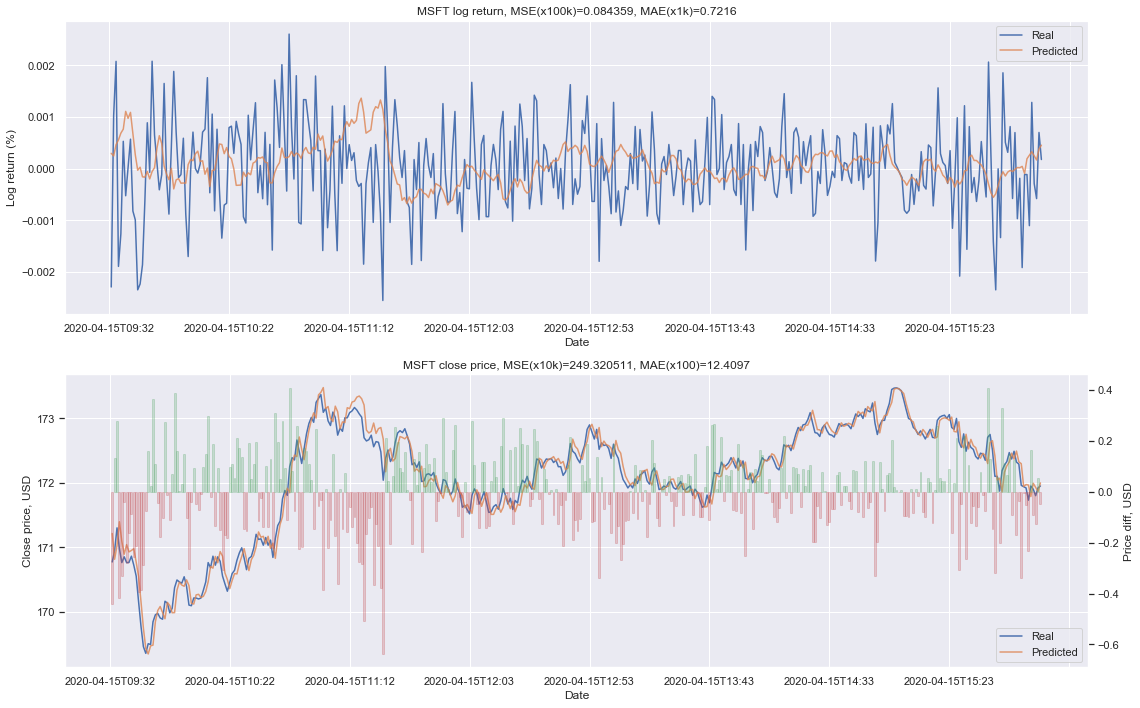

In [39]:
plotHelpers.plot_regr_predictions(orig_target, instr_test, pred_log_ret_test, figsize=(16, 10),
                                  datetime_unit='m', plot_data_slice=slice(1, None))

## Задача классификации

Прогнозируем направление изменения цены по сравнению с предыдущим периодом (**0** - снижение, **1** - рост).

In [40]:
model_class_name = 'classification'

In [41]:
train_clf_gen = ClassificationGenerator.create(train_mwf, batch_size=BATCH_SIZE)
# val_clf_gen = ClassificationGenerator.create(val_mwf, batch_size=BATCH_SIZE, shuffle=False)
test_clf_gen = ClassificationGenerator.create(test_mwf, batch_size=BATCH_SIZE, shuffle=False)

In [42]:
def build_classification_model(input_shape):
    inp, lstm = build_lstm_layers(input_shape, latent_dim=32)

    clf = Dense(64)(lstm)
    clf = LeakyReLU()(clf)
    clf = BatchNormalization()(clf)
    clf = Dropout(0.5)(clf)
    clf = Dense(1, activation='sigmoid', name='clf')(clf)

    return Model(inputs=[inp], outputs=[clf])

In [43]:
multivariate_classification_lstm = build_classification_model(test_clf_gen.input_shape)

model_save_dir = make_model_save_dir(model_path_root, model_type_name, model_class_name)

#### Оптимизатор:

In [44]:
optimizer = Nadam(lr=0.001, clipnorm=0.5)

#### Функция потерь:

In [45]:
multivariate_classification_lstm.compile(optimizer=optimizer,
                                         loss={'clf': 'binary_crossentropy'},
                                         metrics={'clf': 'accuracy'})

multivariate_classification_lstm.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 120, 18)]         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 120, 32)           6528      
_________________________________________________________________
flatten_1 (Flatten)          (None, 3840)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                245824    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0   

#### Дополнительные коллбэки:

In [46]:
checkpointer = ModelCheckpoint(monitor='val_loss', verbose=1, save_best_only=True,
                               filepath=os.path.join(model_save_dir, '{epoch:02d}.hdf5'))

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, verbose=1)

#### Обучение:

In [47]:
clf_history = utils.train_model(multivariate_classification_lstm,
                                model_save_dir, train_clf_gen, test_clf_gen,
                                callbacks=[reduce_lr, lr_scheduler, checkpointer, earlyStopping],
                                force_train=FORCE_TRAIN, verbose=1)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/32
31/32 [============================>.] - ETA: 1s - loss: 7.9469 - accuracy: 0.5232
Epoch 00001: val_loss improved from inf to 6.79274, saving model to models\lstm1_multivar\classification\01.hdf5
32/32 [==============================] - 42s 1s/step - loss: 7.9224 - accuracy: 0.5217 - val_loss: 6.7927 - val_accuracy: 0.4627

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/32
31/32 [============================>.] - ETA: 0s - loss: 6.1546 - accuracy: 0.5615
Epoch 00002: val_loss improved from 6.79274 to 5.30794, saving model to models\lstm1_multivar\classification\02.hdf5
32/32 [==============================] - 39s 1s/step - loss: 6.1317 - accuracy: 0.5641 - val_loss: 5.3079 - val_accuracy: 0.5167

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/32
31/32 [============================>.] - ETA: 1s - loss: 4

31/32 [============================>.] - ETA: 1s - loss: 1.6453 - accuracy: 0.5867
Epoch 00020: val_loss improved from 1.73007 to 1.72009, saving model to models\lstm1_multivar\classification\20.hdf5
32/32 [==============================] - 49s 2s/step - loss: 1.6465 - accuracy: 0.5838 - val_loss: 1.7201 - val_accuracy: 0.4807

Epoch 00021: LearningRateScheduler reducing learning rate to 6.25000029685907e-05.
Epoch 21/32
31/32 [============================>.] - ETA: 1s - loss: 1.6299 - accuracy: 0.5978
Epoch 00021: val_loss improved from 1.72009 to 1.71061, saving model to models\lstm1_multivar\classification\21.hdf5
32/32 [==============================] - 42s 1s/step - loss: 1.6271 - accuracy: 0.5996 - val_loss: 1.7106 - val_accuracy: 0.5013

Epoch 00022: LearningRateScheduler reducing learning rate to 6.25000029685907e-05.
Epoch 22/32
31/32 [============================>.] - ETA: 0s - loss: 1.5727 - accuracy: 0.6573
Epoch 00022: val_loss improved from 1.71061 to 1.70883, saving mode

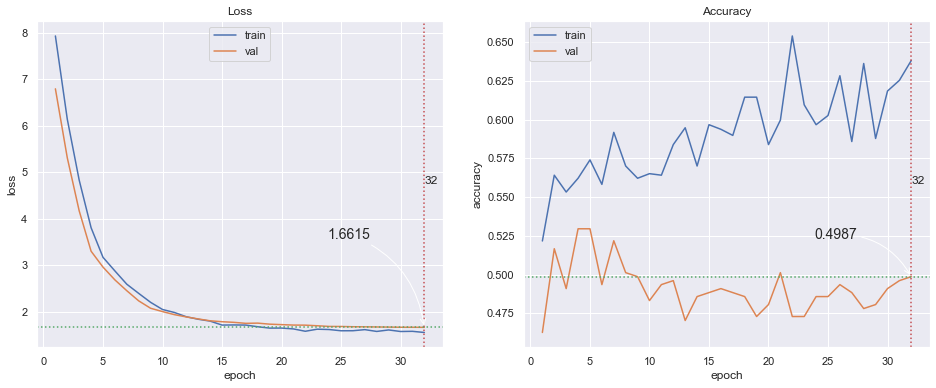

In [48]:
def plot_clf_history(hist):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    plotHelpers.plot_train_history(ax[0], hist, 'Loss', 'loss', 'val_loss')
    plotHelpers.plot_train_history(ax[1], hist, 'Accuracy', 'accuracy', 'val_accuracy')
    
plot_clf_history(clf_history);

### Прогноз задачи классификации

*Разделяющая способность довольно слабая, вероятности обоих классов очень близки к порогу отсечения*.

In [49]:
# загружаем последнюю эпоху с минимальным лоссом
multivariate_classification_lstm.load_weights(sorted(glob.glob(os.path.join(model_save_dir,'*.hdf5')))[-1])

In [50]:
pred_direction_proba = multivariate_classification_lstm.predict_generator(test_clf_gen, verbose=1)

true_direction = test_clf_gen.get_target_direction(test_mwf.target[-len(pred_direction_proba):])

predicted_direction = (np.mean(pred_direction_proba) < pred_direction_proba).astype(np.int)

np.mean(pred_direction_proba)

13/13 [==============================] - 7s 550ms/step


0.5318929

In [51]:
np.unique(true_direction, return_counts=True), \
np.unique(predicted_direction, return_counts=True)

((array([0, 1]), array([203, 186], dtype=int64)),
 (array([0, 1]), array([188, 201], dtype=int64)))

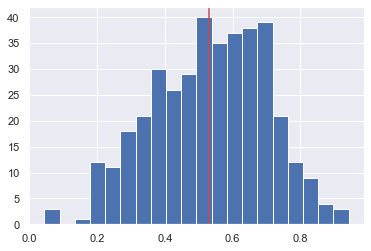

In [52]:
plt.hist(pred_direction_proba, bins=20)
plt.axvline(np.mean(pred_direction_proba), c='r');

In [53]:
print(classification_report(true_direction, predicted_direction))

              precision    recall  f1-score   support

           0       0.50      0.46      0.48       203
           1       0.46      0.49      0.48       186

    accuracy                           0.48       389
   macro avg       0.48      0.48      0.48       389
weighted avg       0.48      0.48      0.48       389



In [54]:
confusion_matrix(true_direction, predicted_direction)

array([[ 94, 109],
       [ 94,  92]], dtype=int64)

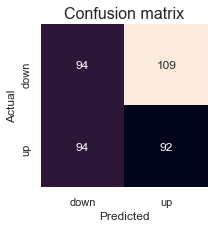

array([[0.5       , 0.54228856],
       [0.5       , 0.45771144]])

In [55]:
plotHelpers.show_confusion_matrix(true_direction, predicted_direction, ['down', 'up'])

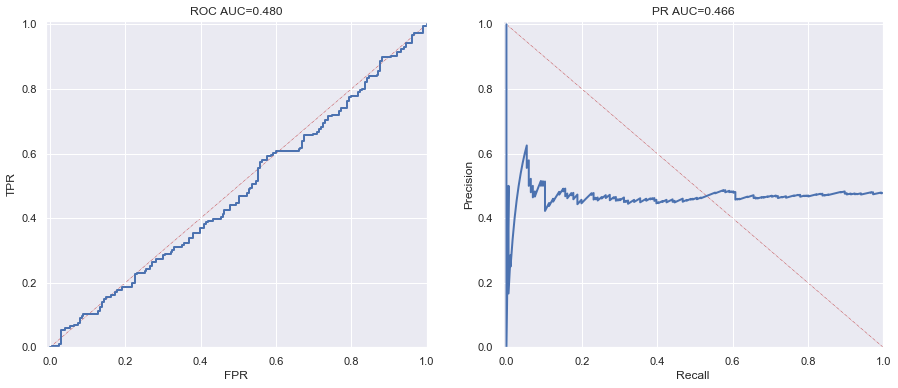

In [56]:
plotHelpers.plot_roc_pr_curves(true_direction, pred_direction_proba)

## Многозадачная модель: одновременно регрессия и классификация

Пытаемся одновременно предсказать и значение цены, и направление изменения, предполагая, что комбинированная ошибка позволит точнее скорректировать веса рекуррентных слоёв.

In [57]:
model_class_name = 'multitask'

In [58]:
train_multi_gen = MultitaskGenerator.create(train_mwf, batch_size=BATCH_SIZE)
# val_multi_gen = MultitaskGenerator.create(val_mwf, batch_size=BATCH_SIZE, shuffle=False)
test_multi_gen = MultitaskGenerator.create(test_mwf, batch_size=BATCH_SIZE, shuffle=False)

In [59]:
def build_multitask_model(input_shape):
    inp, lstm = build_lstm_layers(input_shape, latent_dim=32)

    # первый выход: задача регрссии
    regr = Dense(64)(lstm)
    regr = LeakyReLU()(regr)
    regr = BatchNormalization()(regr)
    regr = Dropout(0.5)(regr)
    regr = Dense(1, activation='linear', name='regr')(regr)

    # второй выход: задача классификации
    clf = Dense(64)(lstm)
    clf = LeakyReLU()(clf)
    clf = BatchNormalization()(clf)
    clf = Dropout(0.5)(clf)
    clf = Dense(1, activation='sigmoid', name='clf')(clf)
    
    return Model(inputs=[inp], outputs=[regr, clf])

In [60]:
multivariate_multitask_lstm = build_multitask_model(train_multi_gen.input_shape)

model_save_dir = make_model_save_dir(model_path_root, model_type_name, model_class_name)

#### Оптимизатор:

In [61]:
optimizer = Nadam(lr=0.001, clipnorm=0.5)

#### Функция потерь:

In [62]:
multivariate_multitask_lstm.compile(optimizer=optimizer,
                                    loss={'regr': 'mse', 'clf': 'binary_crossentropy'},
                                    loss_weights={'regr': 2., 'clf': 1.},
                                    metrics={'regr': 'mae', 'clf' : 'accuracy'})

multivariate_multitask_lstm.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 120, 18)]    0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 120, 32)      6528        input[0][0]                      
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 3840)         0           lstm_2[0][0]                     
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           245824      flatten_2[0][0]                  
____________________________________________________________________________________________

#### Дополнительные коллбэки:

In [63]:
checkpointer = ModelCheckpoint(monitor='val_loss', verbose=1, save_best_only=True,
                               filepath=os.path.join(model_save_dir, '{epoch:02d}.hdf5'))

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, verbose=1)

#### Обучение:

In [64]:
multitask_history = utils.train_model(multivariate_multitask_lstm,
                                      model_save_dir, train_multi_gen, test_multi_gen,
                                      callbacks=[reduce_lr, lr_scheduler, checkpointer, earlyStopping],
                                      force_train=FORCE_TRAIN, verbose=1)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/32
31/32 [============================>.] - ETA: 1s - loss: 16.2625 - regr_loss: 3.7959 - clf_loss: 1.0643 - regr_mae: 1.4502 - clf_accuracy: 0.5091
Epoch 00001: val_loss improved from inf to 10.61184, saving model to models\lstm1_multivar\multitask\01.hdf5
32/32 [==============================] - 43s 1s/step - loss: 16.1519 - regr_loss: 3.7437 - clf_loss: 1.0630 - regr_mae: 1.4441 - clf_accuracy: 0.5079 - val_loss: 10.6118 - val_regr_loss: 1.2419 - val_clf_loss: 0.7237 - val_regr_mae: 0.7692 - val_clf_accuracy: 0.5039

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/32
31/32 [============================>.] - ETA: 0s - loss: 13.2670 - regr_loss: 2.5901 - clf_loss: 0.8974 - regr_mae: 1.1994 - clf_accuracy: 0.5383
Epoch 00002: val_loss improved from 10.61184 to 10.60980, saving model to models\lstm1_multivar\multitask\02.hdf5
32/32 [===================

31/32 [============================>.] - ETA: 1s - loss: 7.6087 - regr_loss: 1.2846 - clf_loss: 0.7262 - regr_mae: 0.8142 - clf_accuracy: 0.6058
Epoch 00014: val_loss improved from 7.50264 to 7.44866, saving model to models\lstm1_multivar\multitask\14.hdf5
32/32 [==============================] - 47s 1s/step - loss: 7.6094 - regr_loss: 1.2863 - clf_loss: 0.7252 - regr_mae: 0.8148 - clf_accuracy: 0.6065 - val_loss: 7.4487 - val_regr_loss: 1.2066 - val_clf_loss: 0.7759 - val_regr_mae: 0.7109 - val_clf_accuracy: 0.4756

Epoch 00015: LearningRateScheduler reducing learning rate to 0.0001250000059371814.
Epoch 15/32
31/32 [============================>.] - ETA: 1s - loss: 7.4844 - regr_loss: 1.2901 - clf_loss: 0.6689 - regr_mae: 0.8191 - clf_accuracy: 0.6512
Epoch 00015: val_loss improved from 7.44866 to 7.38128, saving model to models\lstm1_multivar\multitask\15.hdf5
32/32 [==============================] - 50s 2s/step - loss: 7.4723 - regr_loss: 1.2828 - clf_loss: 0.6723 - regr_mae: 0.817


Epoch 00028: LearningRateScheduler reducing learning rate to 4.999999873689376e-06.
Epoch 28/32
31/32 [============================>.] - ETA: 1s - loss: 7.2067 - regr_loss: 1.2439 - clf_loss: 0.6644 - regr_mae: 0.8008 - clf_accuracy: 0.6532
Epoch 00028: val_loss did not improve from 7.32885
32/32 [==============================] - 52s 2s/step - loss: 7.1746 - regr_loss: 1.2282 - clf_loss: 0.6635 - regr_mae: 0.7994 - clf_accuracy: 0.6519 - val_loss: 7.3296 - val_regr_loss: 1.2467 - val_clf_loss: 0.7830 - val_regr_mae: 0.7257 - val_clf_accuracy: 0.5090

Epoch 00029: LearningRateScheduler reducing learning rate to 4.999999873689376e-06.
Epoch 29/32
31/32 [============================>.] - ETA: 1s - loss: 7.1420 - regr_loss: 1.2250 - clf_loss: 0.6398 - regr_mae: 0.7832 - clf_accuracy: 0.6663
Epoch 00029: val_loss improved from 7.32885 to 7.32411, saving model to models\lstm1_multivar\multitask\29.hdf5
32/32 [==============================] - 41s 1s/step - loss: 7.1428 - regr_loss: 1.2247 

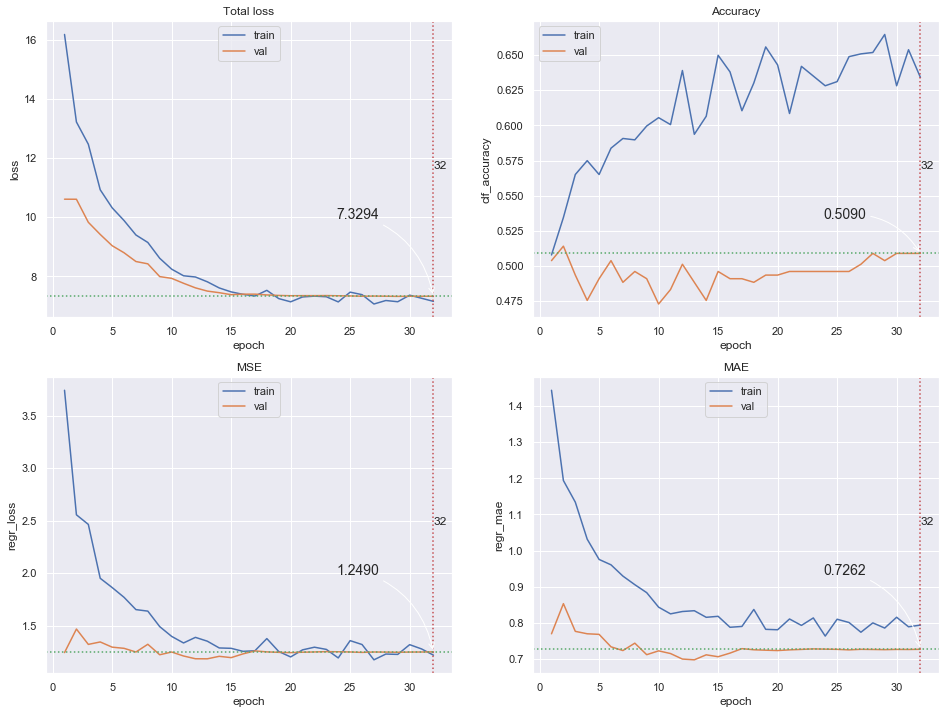

In [65]:
def plot_multitask_history(hist):
    fig, ax = plt.subplots(2, 2, figsize=(16, 12))
    plotHelpers.plot_train_history(ax[0, 0], hist, 'Total loss', 'loss', 'val_loss')
    plotHelpers.plot_train_history(ax[0, 1], hist, 'Accuracy', 'clf_accuracy', 'val_clf_accuracy')
    plotHelpers.plot_train_history(ax[1, 0], hist, 'MSE', 'regr_loss', 'val_regr_loss')
    plotHelpers.plot_train_history(ax[1, 1], hist, 'MAE', 'regr_mae', 'val_regr_mae')
    
plot_multitask_history(multitask_history);

### Прогноз

In [66]:
# загружаем последнюю эпоху с минимальным лоссом
multivariate_multitask_lstm.load_weights(sorted(glob.glob(os.path.join(model_save_dir,'*.hdf5')))[-1])

#### На тесте:

In [67]:
pred_log_ret, pred_direction_proba = multivariate_multitask_lstm.predict_generator(test_multi_gen, verbose=1)

13/13 [==============================] - 7s 547ms/step


In [68]:
np.set_printoptions(precision=3, suppress=True)

np.column_stack([pred_log_ret, pred_direction_proba])[-10:]

array([[-0.128,  0.609],
       [-0.39 ,  0.507],
       [-0.569,  0.49 ],
       [-0.442,  0.601],
       [-0.144,  0.735],
       [ 0.043,  0.865],
       [-0.079,  0.784],
       [-0.149,  0.732],
       [-0.012,  0.749],
       [ 0.126,  0.673]], dtype=float32)

#### Прогноз задачи регрессии

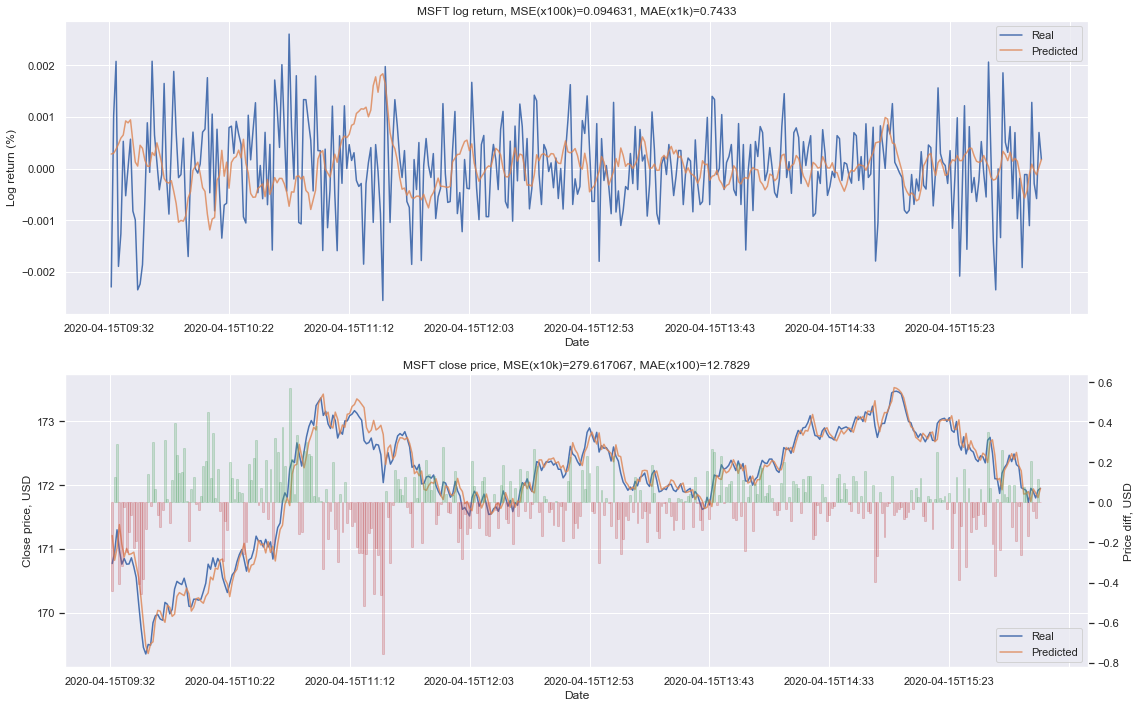

In [69]:
plotHelpers.plot_regr_predictions(orig_target, instr_test, pred_log_ret, figsize=(16, 10),
                                  datetime_unit='m', plot_data_slice=slice(1, None))

#### Прогноз задачи классификации

In [70]:
true_direction = test_clf_gen.get_target_direction(test_mwf.target[-len(pred_direction_proba):])

predicted_direction = (np.mean(pred_direction_proba) < pred_direction_proba).astype(np.int)

np.mean(pred_direction_proba)

0.49700865

In [71]:
true_direction = test_multi_gen.get_target_direction(test_mwf.target[-len(pred_direction_proba):])

predicted_direction = (np.mean(pred_direction_proba) < pred_direction_proba).astype(np.int)

In [72]:
np.unique(true_direction, return_counts=True), \
np.unique(predicted_direction, return_counts=True)

((array([0, 1]), array([203, 186], dtype=int64)),
 (array([0, 1]), array([202, 187], dtype=int64)))

In [73]:
print(classification_report(true_direction, predicted_direction))

              precision    recall  f1-score   support

           0       0.52      0.52      0.52       203
           1       0.48      0.48      0.48       186

    accuracy                           0.50       389
   macro avg       0.50      0.50      0.50       389
weighted avg       0.50      0.50      0.50       389



In [74]:
confusion_matrix(true_direction, predicted_direction)

array([[106,  97],
       [ 96,  90]], dtype=int64)

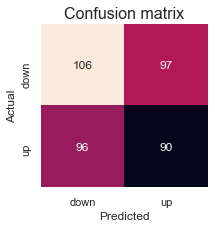

array([[0.525, 0.519],
       [0.475, 0.481]])

In [75]:
plotHelpers.show_confusion_matrix(true_direction, predicted_direction, ['down', 'up'])

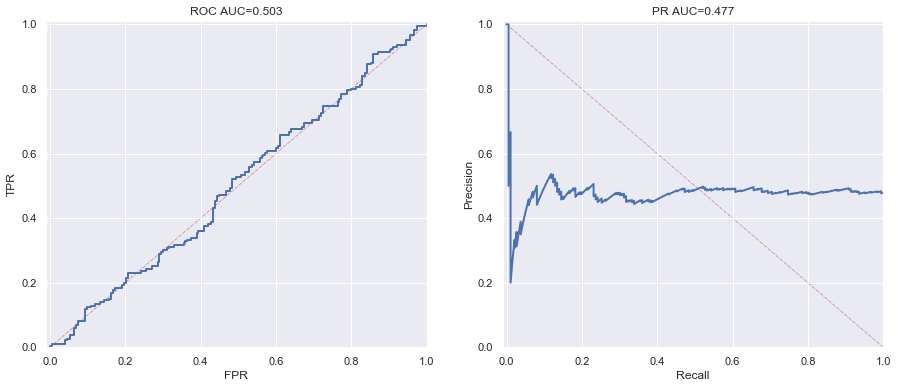

In [76]:
plotHelpers.plot_roc_pr_curves(true_direction, pred_direction_proba)

# Выводы

1.  Размер батча сильно влияет на скорость обучения.
2.  Инициализация весов (`bias_initializer`) в слое **LSTM** оказалась очень важным параметром.
3.  Хотя модель регрессии по метрикам не сильно отличается от модели случайного блуждания, тем не менее она хотя бы не выходит на константное предсказание и пытается выдавать какой-то прогноз.
3.  Задача классификаци не решается удовлетворительно.
5.  Комбинированная (многозадачная) модель не смогла как-то улучшить качество прогнозирования по сравнению с каждой из двух однозадачных моделей.
6. Улучшения в точности прогнозирования по сравнению с одномерной моделью за счёт добавления дополнительных признаков также добиться не удалось.